In [18]:
import networkx as nx
G = nx.petersen_graph()

In [19]:
import matplotlib.pyplot as plt

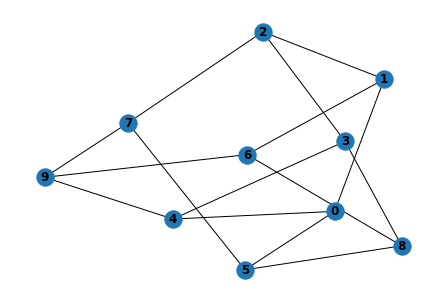

In [20]:
nx.draw(G, with_labels=True, font_weight='bold')

In [26]:
edges = G.edges

edges

EdgeView([(0, 1), (0, 4), (0, 5), (1, 2), (1, 6), (2, 3), (2, 7), (3, 4), (3, 8), (4, 9), (5, 7), (5, 8), (6, 8), (6, 9), (7, 9)])

In [28]:
import numpy as np

In [174]:
for source, target in edges:
    # print(source, target, np.random.randint(low=100, high=1000))
    G[source][target]["capacity"] = np.random.randint(low=25, high=100)

In [175]:
nx.get_edge_attributes(G, "capacity")

{(0, 1): 68,
 (0, 4): 31,
 (0, 5): 58,
 (1, 2): 66,
 (1, 6): 93,
 (2, 3): 66,
 (2, 7): 32,
 (3, 4): 32,
 (3, 8): 79,
 (4, 9): 70,
 (5, 7): 46,
 (5, 8): 33,
 (6, 8): 30,
 (6, 9): 90,
 (7, 9): 36}

In [176]:
edge_capacities = [capacity for capacity in nx.get_edge_attributes(G, "capacity").values()] 
edge_to_idx_map = {edge: i for i, edge in enumerate(edges)}
idx_to_edge_map = {i: edge for i, edge in enumerate(edges)}

In [177]:
edge_to_idx_map

{(0, 1): 0,
 (0, 4): 1,
 (0, 5): 2,
 (1, 2): 3,
 (1, 6): 4,
 (2, 3): 5,
 (2, 7): 6,
 (3, 4): 7,
 (3, 8): 8,
 (4, 9): 9,
 (5, 7): 10,
 (5, 8): 11,
 (6, 8): 12,
 (6, 9): 13,
 (7, 9): 14}

In [178]:
list(nx.shortest_simple_paths(G, 3, 5))[:5]

[[3, 8, 5], [3, 2, 7, 5], [3, 4, 0, 5], [3, 2, 1, 0, 5], [3, 4, 9, 7, 5]]

In [179]:
import random

In [283]:
N = 100

requests = []
for i in range(N):
    zero_to_nine = list(range(10))
    random.shuffle(zero_to_nine)
    source, target = zero_to_nine[:2]
    paths = list(nx.shortest_simple_paths(G, source, target))
    idx = np.random.randint(low=1, high=min(5, len(paths)))
    path = paths[idx]
    edges_taken = [0] * len(edges)
    capacity_needed = np.random.randint(low=1, high=5)
    for j in range(len(path) - 1):
        start, end = min(path[j], path[j+1]), max(path[j], path[j+1])
        edges_taken[edge_to_idx_map[(start, end)]] = capacity_needed
    requests.append(edges_taken)

In [284]:
bids = np.random.randint(low=100, high=250, size=N) + np.floor(np.random.normal(0, 25, size=N))

In [285]:
import cvxpy as cp

In [286]:
# problem data

cvx_b = np.c_[edge_capacities]
cvx_pi = np.c_[bids]
cvx_a = np.array(requests).T

# construct the problem
x = cp.Variable((N, 1), boolean=True)
objective = cp.Maximize(cvx_pi.T @ x)
constraints = [cvx_a @ x <= cvx_b]
prob = cp.Problem(objective, constraints)
prob.solve()
prob.value

13138.0

In [287]:
from copy import deepcopy

In [288]:
class DynamicLearner:

    def __init__(self, epsilon, n, b):
        self.epsilon = epsilon
        self.n = n
        self.b = deepcopy(b)
        self.pi = []
        self.a = []
        self.x = []
        self.t = 0
        self.s = int(epsilon * n)
        self.p_hat = None
        self.allocation_check_rhs = deepcopy(b)
        self.r = np.floor(np.log2(self.s / self.epsilon / self.n)) - 1

    def process_input(self, new_pi, new_a):
        # increment t and add new pi and a values
        self.t += 1
        self.pi.append(new_pi)
        self.a.append(new_a)
        
        # print(self.allocation_check_rhs)

        if self.t <= self.s:
            new_x = 0
        else:        
            
            # check if we need to update p_hat
            if 2 ** (self.r + 1) * self.epsilon * self.n < self.t:
                self.r += 1
                # solve LP to find p_hat using learning phase data           
                # problem data
                cvx_a = np.array(self.a).T
                cvx_pi = np.c_[self.pi]
                cvx_b = np.c_[self.b]

                # construct the problem
                p = cp.Variable((len(self.b), 1))
                y = cp.Variable((self.t, 1))
                const = (1 - self.epsilon * np.sqrt(self.n  / self.t)) * self.t / self.n 
                objective = cp.Minimize(const * cvx_b.T @ p + cp.sum(y))
                constraints = [cvx_a.T @ p + y >= cvx_pi, p >= 0, y >= 0]
                prob = cp.Problem(objective, constraints)
                prob.solve()
                self.p_hat = p.value.T.tolist()[0]  # save p

            # determine allocation amount for the current bid
            allocation = 0
            rhs = 0
            for i in range(len(self.b)):
                rhs += self.p_hat[i] * self.a[-1][i]
            if self.pi[-1] > rhs:
                allocation = 1

            # determine whether to allocate towards the new bid 
            for i in range(len(self.b)):
                if allocation * self.a[-1][i] > self.allocation_check_rhs[i]:
                    new_x = 0
                    break
            else:
                new_x = allocation
            
        # update choices made
        self.x.append(new_x)
        for i in range(len(self.b)):
            self.allocation_check_rhs[i] -= self.a[-1][i] * self.x[-1]

        return new_x
    
    def get_choices(self):
        return self.x

In [289]:
rl_dynamic = []

for _ in range(500):
        
    idx = np.random.permutation(N)
    
    random.shuffle(requests)
    random.shuffle(bids)

    alg = DynamicLearner(0.01, N, edge_capacities)
    for i in range(N):
        alg.process_input(bids[i], requests[i])
    rl_dynamic.append(1 - np.array(bids).dot(alg.get_choices()) / prob.value)

np.average(rl_dynamic)

0.12470650022834526

In [290]:
np.array(bids).dot(alg.get_choices()), prob.value

(11811.0, 13138.0)

In [291]:
class OneTimeLearner:

    def __init__(self, epsilon, n, b):
        self.epsilon = epsilon
        self.n = n
        self.b = deepcopy(b)
        self.pi = []
        self.a = []
        self.x = []
        self.t = 0
        self.s = int(epsilon * n)
        self.p_hat = None
        self.allocation_check_rhs = deepcopy(b)

    def process_input(self, new_pi, new_a):
        
        # increment t and add new pi and a values
        self.t += 1
        self.pi.append(new_pi)
        self.a.append(new_a)

        if self.t <= self.s:
            new_x = 0
            if self.t == self.s:
                # solve LP to find p_hat using learning phase data
                
                # problem data
                cvx_a = np.array(self.a).T
                cvx_pi = np.c_[self.pi]
                cvx_b = np.c_[self.b]
                
                # construct the problem
                p = cp.Variable((len(self.b), 1))
                y = cp.Variable((self.s, 1))
                const = (1 - self.epsilon) * self.s / self.n 
                objective = cp.Minimize(const * cvx_b.T @ p + cp.sum(y))
                constraints = [cvx_a.T @ p + y >= cvx_pi, p >= 0, y >= 0]
                prob = cp.Problem(objective, constraints)
                prob.solve()
                self.p_hat = p.value.T.tolist()[0]  # save p
        else:            
            # determine allocation amount for the current bid
            allocation = 0
            rhs = 0
            for i in range(len(self.b)):
                rhs += self.p_hat[i] * self.a[-1][i]
            if self.pi[-1] > rhs:
                allocation = 1
            
            # determine whether to allocate towards the new bid 
            for i in range(len(self.b)):
                if allocation * self.a[-1][i] > self.allocation_check_rhs[i]:
                    new_x = 0
                    break
            else:
                new_x = allocation

        self.x.append(new_x)
        for i in range(len(self.b)):
            self.allocation_check_rhs[i] -= self.a[-1][i] * self.x[-1]
        return new_x
    
    def get_choices(self):
        return self.x

In [292]:
rl_one_time = []

for _ in range(500):
        
    idx = np.random.permutation(N)
    
    random.shuffle(requests)
    random.shuffle(bids)

    alg = OneTimeLearner(0.1, N, edge_capacities)
    for i in range(N):
        alg.process_input(bids[i], requests[i])
    rl_one_time.append(1 - np.array(bids).dot(alg.get_choices()) / prob.value)

np.average(rl_one_time)

0.2417340538894809

In [293]:
np.array(bids).dot(alg.get_choices()), prob.value

(11394.0, 13138.0)

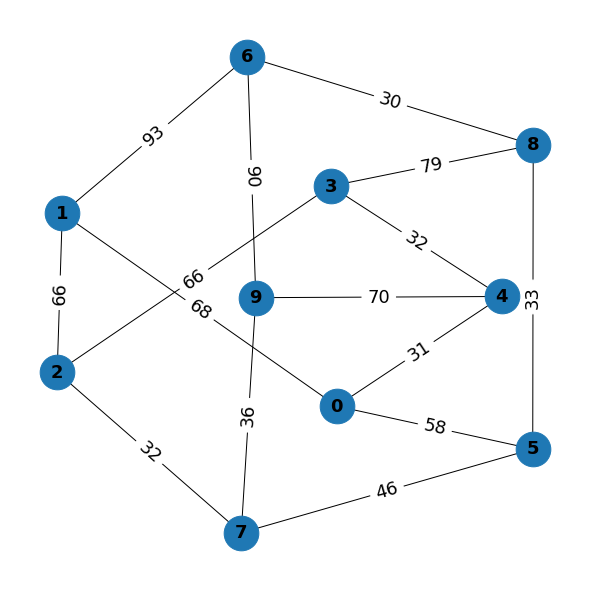

In [235]:
plt.figure(figsize=(8, 8))

pos = nx.spring_layout(G)

nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=1200, font_size=18)

edge_labels = nx.get_edge_attributes(G, 'capacity')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=18)

plt.show()